# Speech Emotion Recognition: A Comparative Study of Different Feature Spaces and Learning Models - 2D Feature Space

## Exploratory Data Analysis


In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Important Libraries
import os
import IPython.display as ipd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display as disp
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from keras import layers
from keras import models
from keras.utils import np_utils
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import opendatasets as od
from keras import backend as K
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import itertools 

In [3]:
# Downloading Crema Dataset from Kaggle
od.download(
    "https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: laraabdelbaki
Your Kaggle Key: ··········


100%|██████████| 987M/987M [00:47<00:00, 21.9MB/s]






## 1. Download the Dataset and Understand the Format (10 Points) 

In [4]:
path = "/content/speech-emotion-recognition-en/Crema/" 

In [5]:
# Dictionary of emotions to convert from the string 
def to_emotion(emotion):
    emotions = {
        'SAD' : 'sad',
        'ANG' : 'angry',
        'DIS' : 'disgust',
        'NEU' : 'neural',
        'HAP' : 'happy',
        'FEA' : 'fear'
    }
    return emotions[emotion]

In [6]:
file_names = os.listdir(path)

In [7]:
# Define 2 empty lists to add the paths and the corresponding emotions
audio_path = []
audio_emotion = []

In [8]:
for file in file_names:
    audio_path.append(os.path.join(path,file))
    emotion = file.split('_')[2]
    audio_emotion.append(to_emotion(emotion))

In [9]:
# Create a Dataframe of audio_path and corresponding audio_emotion
dataset = pd.DataFrame({'path':audio_path,'emotion':audio_emotion})

In [10]:
dataset = dataset.sort_values('path')

In [11]:
dataset

,path,emotion
543,/content/speech-emotion-recognition-en/Crema/1...,angry
4764,/content/speech-emotion-recognition-en/Crema/1...,disgust
7253,/content/speech-emotion-recognition-en/Crema/1...,fear
1258,/content/speech-emotion-recognition-en/Crema/1...,happy
304,/content/speech-emotion-recognition-en/Crema/1...,neural
...,...,...
202,/content/speech-emotion-recognition-en/Crema/1...,disgust
2667,/content/speech-emotion-recognition-en/Crema/1...,fear
292,/content/speech-emotion-recognition-en/Crema/1...,happy
286,/content/speech-emotion-recognition-en/Crema/1...,neural


In [12]:
# One hot encode the labels to be able to map them by the softmax layer
df_encoded_all = pd.get_dummies(dataset, columns=['emotion'])
labels = np.array(df_encoded_all.iloc[:, -6:])
labels

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]], dtype=uint8)

In [13]:
X = dataset.drop(labels="emotion", axis=1)
Y = labels

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.3, shuffle=True, stratify = Y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5209, 1), (2233, 1), (5209, 6), (2233, 6))

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.05, shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((4948, 1), (2233, 1), (261, 1), (4948, 6), (2233, 6), (261, 6))

## 2. Data Augmentation and Feature Extraction for 2D Feature Space

In [ ]:
y, sr = librosa.load("/content/speech-emotion-recognition-en/Crema/1001_DFA_HAP_XX.wav")

In [ ]:
mfcc_feature = librosa.feature.mfcc(y = y, sr=sr)

In [ ]:
mfcc_features = np.transpose(mfcc_feature)

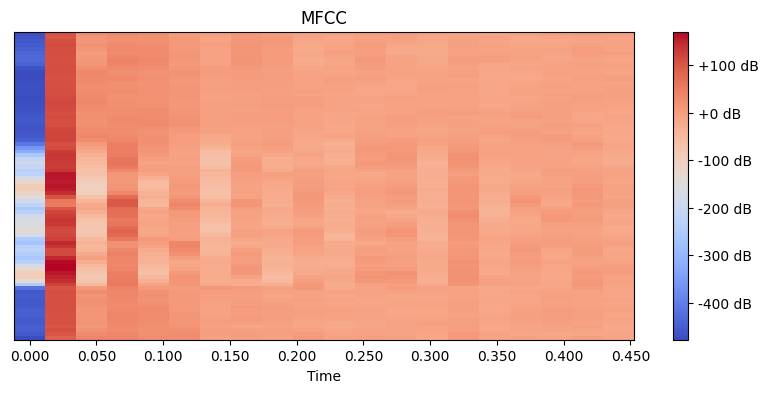

In [ ]:
# Exploring the MFCC of a random sample
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_features, x_axis='time', sr=sr, hop_length=512)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.show()

In [ ]:
mfcc_features.shape

(81, 20)

In [ ]:
y, sr = librosa.load("/content/speech-emotion-recognition-en/Crema/1001_DFA_HAP_XX.wav")

mfcc_feature = librosa.feature.mfcc(y = y, sr=sr)
mfcc_feature.shape

(20, 81)

In [16]:
def noise(data, threshold = 0.075):
    rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp * np.random.normal(size = data.shape[0])
    return data

In [17]:
def pitch(data, sampling_rate, pitch_factor = 0.5):
    pitch_factor = np.random.random()*pitch_factor
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = pitch_factor)

### Processing samples and saving them to a dataset

In [18]:
X_train_new, y_train_new = [], []
print("Feature processing...")
for path, emotion, ind in zip(X_train['path'] ,y_train, range(X_train['path'].shape[0])):
    
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    if len(data) < 110361:
        data = librosa.util.fix_length(data, size=110361)
    else:
        data = data[:110361]
    mfcc_feature = librosa.feature.mfcc(y = data , sr = sample_rate)
    mfcc_feature = np.transpose(mfcc_feature)
    result = np.array(mfcc_feature)
    X_train_new.append(result)
    y_train_new.append(emotion)

    noise_data = noise(data)
    mfcc_feature1 = librosa.feature.mfcc(y = noise_data , sr = sample_rate)
    mfcc_feature1 = np.transpose(mfcc_feature1)
    res2 = np.array(mfcc_feature1)
    X_train_new.append(res2)
    y_train_new.append(emotion)

    pitched_data = pitch(data, sample_rate)
    mfcc_feature2 = librosa.feature.mfcc(y = pitched_data , sr = sample_rate)
    mfcc_feature2 = np.transpose(mfcc_feature2)
    res3 = np.array(mfcc_feature2)
    X_train_new.append(res3)
    y_train_new.append(emotion)

    new_data = pitch(data, sample_rate)
    data_noise_pitch = noise(new_data)
    mfcc_feature3 = librosa.feature.mfcc(y = data_noise_pitch , sr = sample_rate)
    mfcc_feature3 = np.transpose(mfcc_feature3)
    res4 = np.array(mfcc_feature)
    X_train_new.append(res4)
    y_train_new.append(emotion)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
print("Done.")

Feature processing...
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...
1000 samples has been processed...
1100 samples has been processed...
1200 samples has been processed...
1300 samples has been processed...
1400 samples has been processed...
1500 samples has been processed...
1600 samples has been processed...
1700 samples has been processed...
1800 samples has been processed...
1900 samples has been processed...
2000 samples has been processed...
2100 samples has been processed...
2200 samples has been processed...
2300 samples has been processed...
2400 samples has been processed...
2500 samples has been processed...
2600 samples has been processed...
2700 samples has been processed...
2800 sampl

In [23]:
X_test_new, y_test_new = [], []
print("Feature processing...")
for path, emotion, ind in zip(X_test['path'], y_test, range(X_test['path'].shape[0])):
    
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    if len(data) < 110361:
        data = librosa.util.fix_length(data, size=110361)
    else:
        data = data[:110361]
    mfcc_feature = librosa.feature.mfcc(y = data , sr = sample_rate)
    mfcc_feature = np.transpose(mfcc_feature)
    result = np.array(mfcc_feature)
    X_test_new.append(result)
    y_test_new.append(emotion)

    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
print("Done.")

Feature processing...
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...
1000 samples has been processed...
1100 samples has been processed...
1200 samples has been processed...
1300 samples has been processed...
1400 samples has been processed...
1500 samples has been processed...
1600 samples has been processed...
1700 samples has been processed...
1800 samples has been processed...
1900 samples has been processed...
2000 samples has been processed...
2100 samples has been processed...
2200 samples has been processed...
Done.


In [25]:
X_val_new, y_val_new = [], []
print("Feature processing...")
for path, emotion, ind in zip(X_val['path'], y_val, range(X_val['path'].shape[0])):
    
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    if len(data) < 110361:
        data = librosa.util.fix_length(data, size=110361)
    else:
        data = data[:110361]
    mfcc_feature = librosa.feature.mfcc(y = data , sr = sample_rate)
    mfcc_feature = np.transpose(mfcc_feature)
    result = np.array(mfcc_feature)
    X_val_new.append(result)
    y_val_new.append(emotion)

    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
print("Done.")

Feature processing...
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
Done.


In [27]:
# Saving new dataset in a dataframe for further processing
X_train = np.array(X_train_new)
y_train = np.array([arr.tolist() for arr in y_train_new])

In [33]:
# Saving new dataset in a dataframe for further processing
X_test = np.array(X_test_new)
y_test = np.array([arr.tolist() for arr in y_test_new])

In [34]:
# Saving new dataset in a dataframe for further processing
X_val = np.array(X_val_new)
y_val = np.array([arr.tolist() for arr in y_val_new])

In [31]:
mfcc_x, mfcc_y = X_train[0].shape
mfcc_x, mfcc_y

(216, 20)

In [35]:
X_train.shape, X_test.shape, X_val.shape

((19792, 216, 20), (2233, 216, 20), (261, 216, 20))

In [36]:
# Reshape the arrays in order to save them in csv files
arr_reshaped = X_val.reshape(X_val.shape[0], -1)

In [37]:
arr_train = X_train.reshape(X_train.shape[0], -1)

In [38]:
arr_test = X_test.reshape(X_test.shape[0], -1)

___________

The next cell is not needed anymore as it was first used to save the dataframes after the split in google drive 

Note: it is important to save the data after the split to keep training the model on the same X_train and keep the test data unknown

In [ ]:
from numpy import savetxt
savetxt('train_2D.csv', arr_train, delimiter=',')
savetxt('test_2D.csv', arr_test, delimiter=',')
savetxt('val_2D.csv', arr_reshaped, delimiter=',')
savetxt('label_train_2D.csv', y_train, delimiter=',')
savetxt('label_test_2D.csv', y_test, delimiter=',')
savetxt('label_val_2D.csv', y_val, delimiter=',')

## 3. Building The Model (40 Points)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# The dimensions of the csv files
mfcc_x = 216
mfcc_y = 20

In [ ]:
X_val_path = '/content/drive/MyDrive/speech recognition/val_2D.csv'
X_test_path = '/content/drive/MyDrive/speech recognition/test_2D.csv'
X_train_path = '/content/drive/MyDrive/speech recognition/train_2D.csv'
label_val_path = '/content/drive/MyDrive/speech recognition/label_val_2D.csv'
label_test_path = '/content/drive/MyDrive/speech recognition/label_test_2D.csv'
label_train_path = '/content/drive/MyDrive/speech recognition/label_train_2D.csv'

In [ ]:
X_val_trial = pd.read_csv(X_val_path , header = None)
X_test_trial = pd.read_csv(X_test_path , header = None)
X_train_trial = pd.read_csv(X_train_path , header = None)
y_val_trial = pd.read_csv(label_val_path , header = None)
y_train_trial = pd.read_csv(label_train_path , header = None)
y_test_trial = pd.read_csv(label_test_path , header = None)

In [ ]:
X_val_trial = np.array(X_val_trial)
X_train_trial = np.array(X_train_trial)
X_test_trial = np.array(X_test_trial)
y_val = np.array(y_val_trial)
y_test = np.array(y_test_trial)
y_train = np.array(y_train_trial)

In [ ]:
X_val = X_val_trial.reshape(
    X_val_trial.shape[0], X_val_trial.shape[1] // mfcc_y, mfcc_y)

In [ ]:
X_train = X_train_trial.reshape(
    X_train_trial.shape[0], X_train_trial.shape[1] // mfcc_y, mfcc_y)

In [ ]:
X_test = X_test_trial.reshape(
    X_test_trial.shape[0], X_test_trial.shape[1] // mfcc_y, mfcc_y)

In [ ]:
X_val.shape,X_test.shape, X_train.shape

((1042, 216, 20), (8931, 216, 20), (19795, 216, 20))

In [41]:
X_train = np.expand_dims(X_train, axis=3)
X_train.shape

(19792, 216, 20, 1)

In [42]:
X_val = np.expand_dims(X_val, axis=3)
X_val.shape

(261, 216, 20, 1)

In [43]:
X_test = np.expand_dims(X_test, axis=3)
X_test.shape

(2233, 216, 20, 1)

 ### **Accuracy Measures**

In [44]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [45]:
def plot_acc(history):
  fig , ax = plt.subplots(1,2)
  train_acc = history.history['acc']
  train_loss = history.history['loss']
  test_acc = history.history['val_acc']
  test_loss = history.history['val_loss']

  fig.set_size_inches(20,6)
  ax[0].plot(train_loss, label = 'Training Loss')
  ax[0].plot(test_loss , label = 'Testing Loss')
  ax[0].set_title('Training & Testing Loss')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")

  ax[1].plot(train_acc, label = 'Training Accuracy')
  ax[1].plot(test_acc , label = 'Testing Accuracy')
  ax[1].set_title('Training & Testing Accuracy')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  plt.show()

In [46]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### **Callbacks**

In [47]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [48]:
earlystopping = EarlyStopping(monitor ="val_acc",
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)

In [49]:
checkpoint_path  = "/content/drive/MyDrive/speech recognition/weights/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True,
    monitor = 'val_acc',
    mode = 'max')

In [50]:
EPOCHS = 50
batch_size = 32

### **2D CNN Model**

In [51]:
model=models.Sequential()
model.add(layers.Conv2D(256, kernel_size=6, strides=1, padding='same', activation='relu', input_shape=(mfcc_x, mfcc_y , 1)))
model.add(layers.BatchNormalization())
model.add(layers.AveragePooling2D(pool_size=4, strides = 2, padding = 'same'))

model.add(layers.Conv2D(128, kernel_size=6, strides=1, padding='same', activation='relu'))

model.add(layers.BatchNormalization())

model.add(layers.AveragePooling2D(pool_size=4, strides = 2, padding = 'same'))

model.add(layers.Conv2D(128, kernel_size=6, strides=1, padding='same', activation='relu'))
model.add(layers.AveragePooling2D(pool_size=4, strides = 2, padding = 'same'))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, kernel_size=6, strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=4, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(units=6, activation='softmax'))

# Add L2 regularization to the convolutional layers
l2_lambda = 0.01  # Regularization parameter
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
        layer.kernel_regularizer = tf.keras.regularizers.l2(l2_lambda)


model.compile(optimizer = 'adam' ,  loss='categorical_crossentropy' , metrics=["acc", f1_m])


In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 216, 20, 256)      9472      
                                                                 
 batch_normalization (BatchN  (None, 216, 20, 256)     1024      
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 108, 10, 256)     0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 10, 128)      1179776   
                                                                 
 batch_normalization_1 (Batc  (None, 108, 10, 128)     512       
 hNormalization)                                                 
                                                        

## 4. Running the Model and Evaluating Performance

In [53]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 50, batch_size = 64, callbacks=[earlystopping, learning_rate_reduction, cp_callback])

Epoch 1/50
310/310 [==============================] - ETA: 0s - loss: 1.5305 - acc: 0.3684 - f1_m: 0.1617
Epoch 1: val_acc improved from -inf to 0.41379, saving model to /content/drive/MyDrive/speech recognition/weights/cp-0001.ckpt
310/310 [==============================] - 66s 159ms/step - loss: 1.5305 - acc: 0.3684 - f1_m: 0.1617 - val_loss: 1.4148 - val_acc: 0.4138 - val_f1_m: 0.1614 - lr: 0.0010
Epoch 2/50
310/310 [==============================] - ETA: 0s - loss: 1.3690 - acc: 0.4494 - f1_m: 0.2759
Epoch 2: val_acc improved from 0.41379 to 0.44828, saving model to /content/drive/MyDrive/speech recognition/weights/cp-0002.ckpt
310/310 [==============================] - 50s 161ms/step - loss: 1.3690 - acc: 0.4494 - f1_m: 0.2759 - val_loss: 1.3652 - val_acc: 0.4483 - val_f1_m: 0.2776 - lr: 0.0010
Epoch 3/50
310/310 [==============================] - ETA: 0s - loss: 1.2878 - acc: 0.4917 - f1_m: 0.3494
Epoch 3: val_acc improved from 0.44828 to 0.49425, saving model to /content/drive/M

70/70 [==============================] - 2s 23ms/step - loss: 1.2222 - acc: 0.5383 - f1_m: 0.4707
Accuracy of our model on test data :  53.82893085479736 %


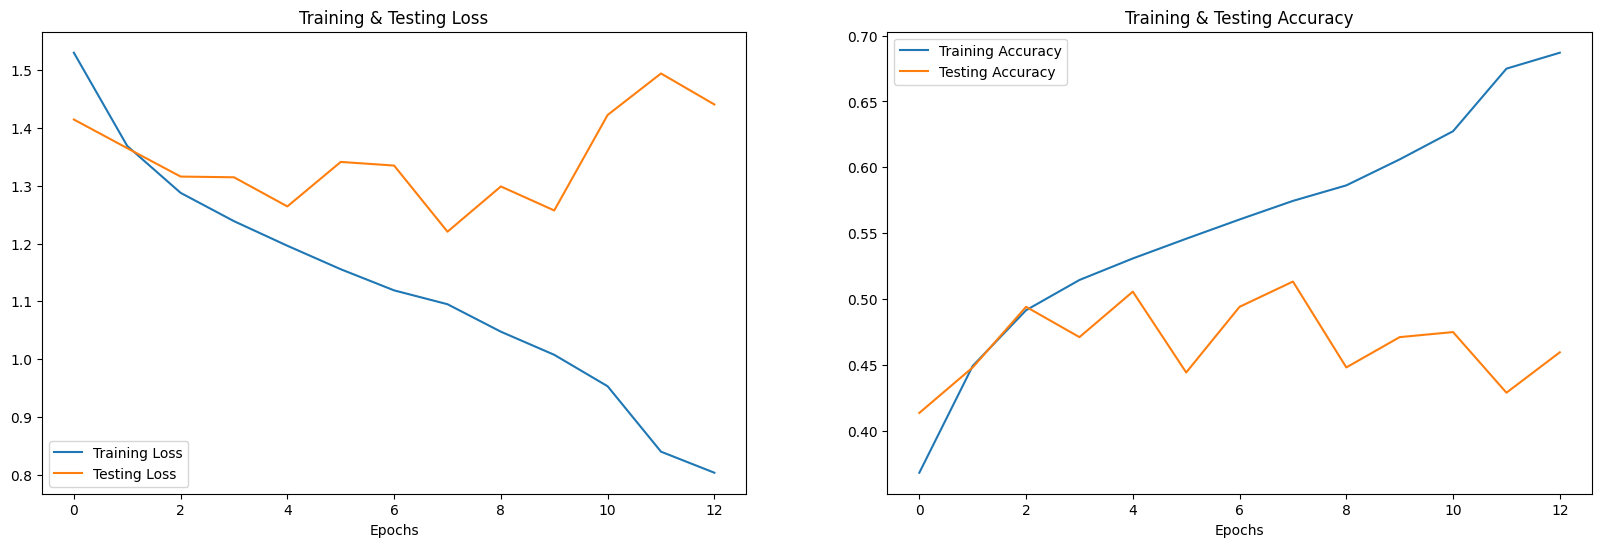

In [54]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")
plot_acc(history)

In [55]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_check = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true=y_check, y_pred=y_pred)

70/70 [==============================] - 1s 16ms/step


Confusion matrix, without normalization
[[260  31  31  49   8   2]
 [ 43 167  35  48  43  46]
 [ 16  26 174  62  11  92]
 [ 52  22  66 204  26  11]
 [  5  37  35  48 164  37]
 [  1  39  41  15  53 233]]


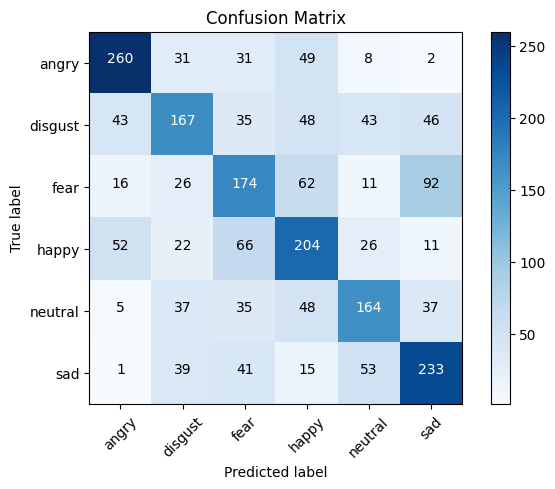

In [56]:
cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')


## 5. Running the model with saved weights. Transfer Learning approach

In [60]:
model.load_weights('/content/drive/MyDrive/speech recognition/weights/cp-0008.ckpt')

In [61]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 10, batch_size = 32, callbacks=[earlystopping, learning_rate_reduction, cp_callback])

Epoch 1/10
619/619 [==============================] - ETA: 0s - loss: 1.1247 - acc: 0.5606 - f1_m: 0.4757
Epoch 1: val_acc improved from 0.51341 to 0.52490, saving model to /content/drive/MyDrive/speech recognition/weights/cp-0001.ckpt
619/619 [==============================] - 56s 87ms/step - loss: 1.1247 - acc: 0.5606 - f1_m: 0.4757 - val_loss: 1.2622 - val_acc: 0.5249 - val_f1_m: 0.4170 - lr: 0.0010
Epoch 2/10
619/619 [==============================] - ETA: 0s - loss: 1.0651 - acc: 0.5814 - f1_m: 0.5149
Epoch 2: val_acc did not improve from 0.52490
619/619 [==============================] - 53s 85ms/step - loss: 1.0651 - acc: 0.5814 - f1_m: 0.5149 - val_loss: 1.3944 - val_acc: 0.5057 - val_f1_m: 0.4409 - lr: 0.0010
Epoch 3/10
619/619 [==============================] - ETA: 0s - loss: 1.0162 - acc: 0.6046 - f1_m: 0.5463
Epoch 3: val_acc did not improve from 0.52490
619/619 [==============================] - 53s 86ms/step - loss: 1.0162 - acc: 0.6046 - f1_m: 0.5463 - val_loss: 1.2804 

In [62]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

70/70 [==============================] - 1s 17ms/step - loss: 1.2372 - acc: 0.5419 - f1_m: 0.4737
Accuracy of our model on test data :  54.187190532684326 %


## Bonus Part

**Architecture from paper: *Recognition of Emotions in Speech Using Convolutional
Neural Networks on Different Datasets***



> The architecture consists of a Sequential Keras model with several layers. The first layer is a Conv2D layer with 75 filters, a kernel size of 5x5, and a ReLU activation function. It takes input of shape (mfcc_x, mfcc_y, 1), where mfcc_x and mfcc_y represent the dimensions of the input MFCC features. The layer is followed by a MaxPooling2D layer with a pool size of 4x4 and a stride of 2. The architecture then repeats this pattern with another Conv2D layer with 135 filters, a MaxPooling2D layer, and a Dropout layer with a rate of 0.2, for regularization. The architecture then repeats the pattern once again with a Conv2D layer with 75 filters and a MaxPooling2D layer. The output of this layer is then flattened and passed through a Dense layer with 45 units and a ReLU activation function, followed by another Dropout layer with a rate of 0.2. Finally, the output is passed through a Dense layer with 6 units and a softmax activation function, to produce the final classification probabilities. L2 regularization with a parameter of 0.01 is applied to the Conv2D and Dense layers. The model is compiled using the Adam optimizer and the categorical cross-entropy loss function, with accuracy and F1 score as the evaluation metrics. Overall, this architecture is designed for classifying audio signals using MFCC features, with a focus on preventing overfitting through regularization and L2 regularization.



In [64]:
import tensorflow as tf

model_b=models.Sequential()
model_b.add(layers.Conv2D(75, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(mfcc_x, mfcc_y , 1)))
#model.add(layers.MaxPooling2D(pool_size=4, strides = 2, padding = 'same'))
model_b.add(layers.MaxPooling2D(pool_size=4, strides = 2, padding = 'same'))

model_b.add(layers.Conv2D(135, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(mfcc_x, mfcc_y , 1)))
model_b.add(layers.MaxPooling2D(pool_size=4, strides = 2, padding = 'same'))

model_b.add(layers.Dropout(0.2))

model_b.add(layers.Conv2D(75, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(mfcc_x, mfcc_y , 1)))
model_b.add(layers.MaxPooling2D(pool_size=4, strides = 2, padding = 'same'))

model_b.add(layers.Dropout(0.2))

model_b.add(layers.Flatten())

model_b.add(layers.Dense(units=45, activation='relu'))

model_b.add(layers.Dropout(0.2))

model_b.add(layers.Dense(units=6, activation='softmax'))


# Add L2 regularization to the convolutional layers
l2_lambda = 0.01  # Regularization parameter
for layer in model_b.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
        layer.kernel_regularizer = tf.keras.regularizers.l2(l2_lambda)


model_b.compile(optimizer = 'adam' ,  loss='categorical_crossentropy' , metrics=["acc", f1_m])

In [65]:
model_b.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 216, 20, 75)       1950      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 108, 10, 75)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 108, 10, 135)      253260    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 54, 5, 135)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 54, 5, 135)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 54, 5, 75)        

In [ ]:
history = model_b.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 30, batch_size = 64)

Epoch 1/30
310/310 [==============================] - 28s 42ms/step - loss: 2.9183 - acc: 0.1720 - f1_m: 0.0042 - val_loss: 1.7897 - val_acc: 0.1727 - val_f1_m: 0.0000e+00
Epoch 2/30
310/310 [==============================] - 12s 40ms/step - loss: 1.7851 - acc: 0.1793 - f1_m: 0.0076 - val_loss: 1.7886 - val_acc: 0.1727 - val_f1_m: 0.0000e+00
Epoch 3/30
310/310 [==============================] - 13s 41ms/step - loss: 1.7904 - acc: 0.1693 - f1_m: 0.0000e+00 - val_loss: 1.7884 - val_acc: 0.1641 - val_f1_m: 0.0000e+00
Epoch 4/30
310/310 [==============================] - 13s 41ms/step - loss: 1.7904 - acc: 0.1694 - f1_m: 0.0000e+00 - val_loss: 1.7882 - val_acc: 0.1641 - val_f1_m: 0.0000e+00
Epoch 5/30
310/310 [==============================] - 13s 41ms/step - loss: 1.7909 - acc: 0.1689 - f1_m: 0.0000e+00 - val_loss: 1.7882 - val_acc: 0.1641 - val_f1_m: 0.0000e+00
Epoch 6/30
310/310 [==============================] - 13s 41ms/step - loss: 1.7905 - acc: 0.1674 - f1_m: 0.0000e+00 - val_loss: 

In [ ]:
print("Accuracy of our model on test data : " , model_b.evaluate(X_test,y_test)[1]*100 , "%")

280/280 [==============================] - 4s 13ms/step - loss: 1.7902 - acc: 0.1708 - f1_m: 0.0000e+00
Accuracy of our model on test data :  17.075355350971222 %
